In [ ]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.fig_utils import full_dist_to_print, dataset_to_print, dist_to_color, dist_to_print
from utils.io_utils import load_multiple_res
from utils.pd_utils import compute_outlier_scores, filter_dgms
import os
import numpy as np

In [2]:
style_file = "utils.style"
plt.style.use(style_file)

In [3]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Fig datasets

In [4]:
datasets = ["toy_circle", "inter_circles", "eyeglasses", "torus", "toy_sphere"]

embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]
n = 1000

# different datas
sigmas_per_dataset = {}
for dataset in datasets:
    if dataset == "eyeglasses":
        sigmas_per_dataset[dataset] = sigmas[:13]
    else:
        sigmas_per_dataset[dataset] = sigmas

## Find best hyperparameters

In [ ]:
# The best hyperparameters are hard-coded below and do not have to be reselected, unless the set of methods and possible hyperparameters is changed.

In [100]:
distances = {
    "euclidean": [{}],
    "fermat": [
               {"p": 2},
               {"p": 3},
               {"p": 5},
               {"p": 7}
               ],
    "dtm": [
            {"k": 4, "p_dtm": 2, "p_radius": 1},
            {"k": 4, "p_dtm": np.inf, "p_radius": 1},
            {"k": 15, "p_dtm": 2, "p_radius": 1},
            {"k": 15, "p_dtm": np.inf, "p_radius": 1},
            {"k": 100, "p_dtm": 2, "p_radius": 1},
            {"k": 100, "p_dtm": np.inf, "p_radius": 1},

            {"k": 4, "p_dtm": 2, "p_radius": 2},
            {"k": 4, "p_dtm": np.inf, "p_radius": 2},
            {"k": 15, "p_dtm": 2, "p_radius": 2},
            {"k": 15, "p_dtm": np.inf, "p_radius": 2},
            {"k": 100, "p_dtm": 2, "p_radius": 2},
            {"k": 100, "p_dtm": np.inf, "p_radius": 2},

            {"k": 4, "p_dtm": 2, "p_radius": np.inf},
            {"k": 4, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 15, "p_dtm": 2, "p_radius": np.inf},
            {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 100, "p_dtm": 2, "p_radius": np.inf},
            {"k": 100, "p_dtm": np.inf, "p_radius": np.inf},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    ],
    "diffusion": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
}


In [101]:
#load data
all_res = {}
for dataset in datasets:
    all_res[dataset] = load_multiple_res(datasets=dataset,
                                         distances=distances,
                                         root_path=get_path("data"),
                                         n=n,
                                         seeds=seeds,
                                         sigmas=sigmas_per_dataset[dataset],
                                         embd_dims=embd_dim,
                                         n_threads=10)

Done with toy_circle 50 euclidean
Done with toy_circle 50 fermat_p_2
Done with toy_circle 50 fermat_p_3
Done with toy_circle 50 fermat_p_5
Done with toy_circle 50 fermat_p_7
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_1
Done with toy_circle 50 dtm_k_4_p_dtm_inf_p_radius_1
Done with toy_circle 50 dtm_k_15_p_dtm_2_p_radius_1
Done with toy_circle 50 dtm_k_15_p_dtm_inf_p_radius_1
Done with toy_circle 50 dtm_k_100_p_dtm_2_p_radius_1
Done with toy_circle 50 dtm_k_100_p_dtm_inf_p_radius_1
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_2
Done with toy_circle 50 dtm_k_4_p_dtm_inf_p_radius_2
Done with toy_circle 50 dtm_k_15_p_dtm_2_p_radius_2
Done with toy_circle 50 dtm_k_15_p_dtm_inf_p_radius_2
Done with toy_circle 50 dtm_k_100_p_dtm_2_p_radius_2
Done with toy_circle 50 dtm_k_100_p_dtm_inf_p_radius_2
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_inf
Done with toy_circle 50 dtm_k_4_p_dtm_inf_p_radius_inf
Done with toy_circle 50 dtm_k_15_p_dtm_2_p_radius_inf
Done with toy_circle 50 dtm_

In [102]:
# filtering
dob = 1.25
all_res = filter_dgms(dgms=all_res, dob=dob, dim=1, binary=True)
all_res = filter_dgms(dgms=all_res, dob=dob, dim=2, binary=True)

In [103]:
# compute the detection score
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "inter_circles": 2,
        "eyeglasses": 1,
        "torus": 2,
        "toy_sphere": 0,  # so that the curves are high for AUC
    },
    2: {
        "toy_sphere": 1,
        "torus": 1 
    }
}

outlier_scores_1d = {dataset: compute_outlier_scores(all_res[dataset], 
                                                     n_features=cycles_per_dataset[1][dataset],
                                                     dim=1)
                     for dataset in cycles_per_dataset[1]}
outlier_scores_2d = {dataset: compute_outlier_scores(all_res[dataset],
                                                     n_features=cycles_per_dataset[2][dataset],
                                                     dim=2)
                     for dataset in cycles_per_dataset[2]}

outlier_scores = {
    1: outlier_scores_1d,
    2: outlier_scores_2d
}

In [104]:
# compute area under the curves
aucs = {}

for feature_dim in outlier_scores:
    auc_by_feature_dim = {}
    for dataset in outlier_scores[feature_dim]:
        auc_by_dataset = {}
        for dist in outlier_scores[feature_dim][dataset]:
            auc_per_method = {}
            for full_dist in outlier_scores[feature_dim][dataset][dist]:
                auc_per_method[full_dist] = outlier_scores[feature_dim][dataset][dist][full_dist].mean(1).sum() / len(sigmas_per_dataset[dataset])
            auc_by_dataset[dist] = auc_per_method
        auc_by_feature_dim[dataset] = auc_by_dataset
    aucs[feature_dim] = auc_by_feature_dim

In [105]:
# Each panel selects the best method individually. This means different feature dimensions for torus and sphere can select different hyperparameters.

best_method_per_dataset = {}
for feature_dim in aucs:
    best_method_per_feature_dim = {}

    for dataset in aucs[feature_dim]:
        best_method_this_dataset = {}
        for dist in aucs[feature_dim][dataset]:
            best_full_dist = None
            best_auc = 0
            for full_dist in aucs[feature_dim][dataset][dist]:
                auc = aucs[feature_dim][dataset][dist][full_dist]
                if auc > best_auc:
                    best_auc = auc
                    best_full_dist = full_dist
            best_method_this_dataset[dist] = best_full_dist
        best_method_per_feature_dim[dataset] = best_method_this_dataset
    best_method_per_dataset[feature_dim] = best_method_per_feature_dim

In [107]:
# print best hyperparameter settings 
for feature_dim in best_method_per_dataset:
    print("~"*40)
    print(f"Topological dimension: {feature_dim}")
    for dataset in best_method_per_dataset[feature_dim]:
        for dist in best_method_per_dataset[feature_dim][dataset]:
            print(dataset_to_print[dataset], full_dist_to_print[best_method_per_dataset[feature_dim][dataset][dist]].replace("\n", " "))
        print("\n")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Topological dimension: 1
Circle Euclidean
Circle Fermat $p=3$
Circle DTM $k=4, p=2, \xi=1$
Circle Effective resistance $k=100$
Circle Diffusion $k=100, t=8$


Linked circles Euclidean
Linked circles Fermat $p=7$
Linked circles DTM $k=15, p=\infty, \xi=1$
Linked circles Effective resistance $k=15$
Linked circles Diffusion $k=15, t=8$


Eyeglasses Euclidean
Eyeglasses Fermat $p=7$
Eyeglasses DTM $k=100, p=2, \xi=1$
Eyeglasses Effective resistance $k=15$
Eyeglasses Diffusion $k=15, t=64$


Torus Euclidean
Torus Fermat $p=2$
Torus DTM $k=4, p=2, \xi=\infty$
Torus Effective resistance $k=100$
Torus Diffusion $k=15, t=8$


Sphere Euclidean
Sphere Fermat $p=2$
Sphere DTM $k=100, p=2, \xi=1$
Sphere Effective resistance $k=15$
Sphere Diffusion $k=100, t=64$


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Topological dimension: 2
Sphere Euclidean
Sphere Fermat $p=2$
Sphere DTM $k=4, p=2, \xi=1$
Sphere Effective resistance $k=100$
Sphere Diffusion $k=100, t=8$


## preselected best hyperparameters

In [5]:
# This can be run without loading all hyperparameter settings from above. The following dictionary contains the best hyperparameters for each dataset and distance as kwargs instead of as string, so that we can use the normal method for loading results.
best_method_per_dataset_dict = {
    1: {'toy_circle': 
            {'euclidean': [{}], 
             'fermat': [{"p": 3}], 
             'dtm': [{"k": 4, "p_dtm": 2, "p_radius": 1},], 
             'eff_res': [{"corrected": True, "weighted": False, "k": 100, "disconnect": True,}], 
             'diffusion': [{"k": 100, "t": 8, "kernel": "sknn", "include_self": False}], 
             },
        'inter_circles': 
            {'euclidean': [{}], 
             'fermat': [{"p": 7}], 
             'dtm': [{"k": 15, "p_dtm": np.inf, "p_radius": 1},],
             'eff_res': [{"corrected": True, "weighted": False, "k": 15, "disconnect": True,}], 
             'diffusion': [{"k": 15, "t": 8, "kernel": "sknn", "include_self": False}],
             },
        'eyeglasses': 
            {'euclidean': [{}],
             'fermat': [{"p": 7}],
             'dtm': [{"k": 100, "p_dtm": 2, "p_radius": 1},], 
             'eff_res': [{"corrected": True, "weighted": False, "k": 15, "disconnect": True,}],
             'diffusion':  [{"k": 15, "t": 64, "kernel": "sknn", "include_self": False}], 
             },
        'torus': 
            {'euclidean': [{}], 
             'fermat': [{"p": 2}], 
             'dtm': [{"k": 4, "p_dtm": 2, "p_radius": np.inf},], 
             'eff_res': [{"corrected": True, "weighted": False, "k": 100, "disconnect": True,}],
             'diffusion': [{"k": 15, "t": 8, "kernel": "sknn", "include_self": False}],
             },
        'toy_sphere':
            {
                "euclidean" : [{}],
                "fermat" : [{"p": 2}],
                "dtm" : [{"k": 100, "p_dtm": 2, "p_radius": 1}],
                "eff_res" : [{"corrected": True, "weighted": False, "k": 15, "disconnect": True}],
                "diffusion" : [{"k": 100, "t": 64, "kernel": "sknn", "include_self": False}],
            }
        },
    2: {'torus': 
            {'euclidean': [{}],
             'fermat': [{"p": 2}], 
             'dtm': [{"k": 4, "p_dtm": 2, "p_radius": np.inf},], 
             'eff_res': [{"corrected": True, "weighted": False, "k": 100, "disconnect": True,}],
             'diffusion': [{"k": 15, "t": 8, "kernel": "sknn", "include_self": False}]},
        'toy_sphere':
            {
                "euclidean" : [{}],
                "fermat" : [{"p": 2}],
                "dtm" : [{"k": 4, "p_dtm": 2, "p_radius": 1}],
                "eff_res" : [{"corrected": True, "weighted": False, "k": 100, "disconnect": True}],
                "diffusion" : [{"k": 100, "t": 8, "kernel": "sknn", "include_self": False}],
            }
        }
}

In [6]:
selected_res = {}
for feature_dim in best_method_per_dataset_dict:
    sel_res_dim = {}
    for dataset in best_method_per_dataset_dict[feature_dim]:
        sel_res_dim[dataset] = load_multiple_res(datasets=dataset, 
                                                  distances=best_method_per_dataset_dict[feature_dim][dataset],
                                                  root_path=root_path,
                                                  n=n,
                                                  seeds=seeds,
                                                  sigmas=sigmas_per_dataset[dataset],
                                                  embd_dims=embd_dim, 
                                                  n_threads=10)
    selected_res[feature_dim] = sel_res_dim

Done with toy_circle 50 euclidean n_outliers=0
Done with toy_circle 50 fermat_p_3 n_outliers=0
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0
Done with toy_circle 50 diffusion_k_100_t_8_kernel_sknn_include_self_False n_outliers=0
Done with inter_circles 50 euclidean n_outliers=0
Done with inter_circles 50 fermat_p_7 n_outliers=0
Done with inter_circles 50 dtm_k_15_p_dtm_inf_p_radius_1 n_outliers=0
Done with inter_circles 50 eff_res_corrected_True_weighted_False_k_15_disconnect_True n_outliers=0
Done with inter_circles 50 diffusion_k_15_t_8_kernel_sknn_include_self_False n_outliers=0
Done with eyeglasses 50 euclidean n_outliers=0
Done with eyeglasses 50 fermat_p_7 n_outliers=0
Done with eyeglasses 50 dtm_k_100_p_dtm_2_p_radius_1 n_outliers=0
Done with eyeglasses 50 eff_res_corrected_True_weighted_False_k_15_disconnect_True n_outliers=0
Done with eyeglasses 50 diffusion_k_15_

In [7]:
# filtering
dob = 1.25
for feature_dim in selected_res:
    selected_res[feature_dim] = filter_dgms(dgms=selected_res[feature_dim], dob=dob, binary=True, dim=feature_dim)

In [8]:
# compute the detection scores for each method
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "eyeglasses": 1,
        "toy_sphere": 1,  # so that the curves are low
        "torus": 2,
        "inter_circles": 2,
        #"toy_blob": 1, # so that the curves are low
    },
    2: {
        "toy_sphere": 1,
        "torus": 1 
    }
}
selected_outlier_scores_1d = {dataset: compute_outlier_scores(selected_res[1][dataset],
                                                              n_features=cycles_per_dataset[1][dataset],
                                                              dim=1)
                     for dataset in cycles_per_dataset[1]}
selected_outlier_scores_2d = {dataset: compute_outlier_scores(selected_res[2][dataset],
                                                              n_features=cycles_per_dataset[2][dataset],
                                                              dim=2)
                     for dataset in cycles_per_dataset[2]}

selected_outlier_scores = {
    1: selected_outlier_scores_1d,
    2: selected_outlier_scores_2d,
}

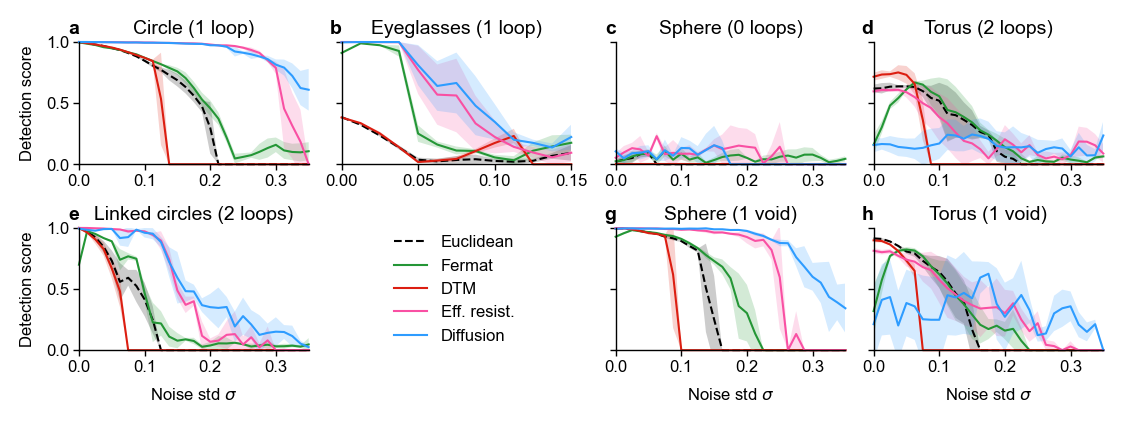

In [9]:
# plot figure
npanels = len(cycles_per_dataset[1]) + len(cycles_per_dataset[2]) +1
nrows = 2
ncols =  int(np.ceil(npanels /2))


fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5.5, 2.))

y_label="Detection score"

letters = "abcdefgh"

shift = 0

for i in range(npanels):
    feature_dim = 1 if i < len(cycles_per_dataset[1]) else 2
    if i == 5: 
        shift = 1
        continue
    j = (i-shift) % len(cycles_per_dataset[1])
    dataset = list(cycles_per_dataset[feature_dim].keys())[j]
    
    r, c  = int(i / ncols), i % ncols
    
    for dist in selected_res[feature_dim][dataset]:
        full_dist = list(selected_res[feature_dim][dataset][dist].keys())[0]
        mean = selected_outlier_scores[feature_dim][dataset][dist][full_dist].mean(1)
        std = selected_outlier_scores[feature_dim][dataset][dist][full_dist].std(1)
        
        if dist != "euclidean":
            ax[r, c].plot(sigmas_per_dataset[dataset], 
                       mean,
                       label=dist_to_print[dist],
                       color=dist_to_color[dist],
                       clip_on=False)
            ax[r, c].fill_between(
                sigmas_per_dataset[dataset],
                mean - std,
                mean + std,
                alpha=0.2,
                color=dist_to_color[dist],
                edgecolor=None,
            )
            
        else:
            ax[r, c].plot(sigmas_per_dataset[dataset], 
                          mean,
                          label=dist_to_print[dist],
                          color=dist_to_color[dist],
                          clip_on=False,
                          linestyle="dashed")
            ax[r, c].fill_between(
                sigmas_per_dataset[dataset],
                mean - std,
                mean + std,
                alpha=0.2,
                color=dist_to_color[dist],
                edgecolor=None,
            )       
        
    ax[r, c].set_ylim(0, 1)
    ax[r, c].set_xlim(0, sigmas_per_dataset[dataset].max())
    ax[r, c].set_xlabel("Noise std $\sigma$")
    if c==0:
        ax[r, c].set_ylabel(y_label)
        
    if c > 0:
        ax[r, c].set_yticklabels([])
    if r == 0:
        ax[r, c].set_xlabel("")
        
        
    if i == 0 or i==1:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (1 loop)")
    elif i == 2:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (0 loops)")
    elif i==3 or i==4:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (2 loops)")
    elif i==6 or i==7:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (1 void)")  
    
    
    ax[r, c].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)


handles, labels = ax[1, 2].get_legend_handles_labels()
ax[1, 1].legend(loc=(0.2, 0.0),
                handles=handles,
             frameon=False
      )
ax[1, 1].axis("off")
fig.savefig(os.path.join(fig_path, "fig_datasets_dob.pdf"))

## Investigate high uncertainty settings on the eyeglasses dataset

In [77]:
from utils.toydata_utils import  get_toy_data
from utils.fig_utils import  plot_dgm_loops
from sklearn.decomposition import PCA

In [78]:
dataset = "eyeglasses"
sigma = 0.075
data = np.stack([get_toy_data(dataset=dataset, n=1000, gaussian={"sigma": sigma}, seed=seed) for seed in seeds])

In [ ]:
# plot figure for eff res
fig, ax = plt.subplots(ncols=3, nrows=3, width_ratios=(1, 2, 2), figsize=(4, 2.5))

titles = ["1D PD", "Representatives"]
letters = "ab"
for i, seed in enumerate(seeds):
    plot_dgm_loops(res=selected_res[1][dataset]["eff_res"]["eff_res_corrected_True_weighted_False_k_15_disconnect_True"][sigma][seed], 
                   embd=PCA(n_components=2).fit_transform(data[i]),
                   y="k",
                   ax=ax[i],
                   plot_only=[1],
                   linewidth=1
                   )
    ax[i, 0].legend().remove()
    ax[i, 0].spines["right"].set_visible(False)
    ax[i, 0].spines["top"].set_visible(False)
    ax[i, 0].set_yticklabels([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_xticks([])
    ax[i, 0].set_xticklabels([])
    
    if i <2:
        ax[i, 0].set_xlabel("")


ax[0, 0].set_title(
    "a",
    loc="left",
    ha="right",
    fontweight="bold",
)
ax[0, 0].set_title("1D PC", loc="center")
    
ax[0, 1].text(
    s="b",
    x=0,
    y=1.14,
    transform=ax[0, 1].transAxes,
    ha="right",
    fontweight="bold",
)
ax[0, 1].text(
    s="Representatives on 2D PCA", 
    x=0.25,
    y=1.14,
    transform=ax[0, 1].transAxes,
)
    
fig.savefig(os.path.join(fig_path, "eyeglasses_eff_res_stability.pdf"))

In [ ]:
# plot figure for diffusion
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5.5, 2.5))

for i, seed in enumerate(seeds):
    plot_dgm_loops(res=selected_res[1][dataset]["diffusion"]["diffusion_k_15_t_64_kernel_sknn_include_self_False"][sigma][seed], 
                   embd=PCA(n_components=2).fit_transform(data[i]),
                   y="k",
                   ax=ax[i],
                   plot_only=[1]
                   )